In [2]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import glob
import numpy as np
import sys, os
import netCDF4 as nc
import xarray as xr
from IPython import display
from tqdm.notebook import trange, tqdm

from mpl_toolkits.basemap import Basemap
from pyresample import kd_tree,geometry
from pyresample import load_area, save_quicklook, SwathDefinition

directory = '../Data/'
files = glob.glob(directory + 'iceh.*.nc')

ds = nc.Dataset(files[0])

lat = ds.variables["TLAT"]
lon = ds.variables["TLON"]

Months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

freqs = np.array([7,10,18,37,89])
ice_type = 'firstyear'
iceConc = 1

TbV,TbH, smrtV,smrtH = [np.empty([len(files),len(freqs),888, 781]) for _ in range(4)]

In [3]:
# load numpy array from csv file
from numpy import loadtxt
# load array
smrtV[0,0,:,:] = loadtxt(directory + 'smrtRunV.csv', delimiter=',')
TbV[0,0,:,:] = loadtxt(directory + 'TieRunV.csv', delimiter=',')
smrtH[0,0,:,:] = loadtxt(directory + 'smrtRunH.csv', delimiter=',')
TbH[0,0,:,:] = loadtxt(directory + 'TieRunH.csv', delimiter=',')


In [13]:
def ArcticPlot(lat,lon,data,*C):   
    
    d = data
    
    Data = np.ma.array(d,   mask = d < .1)
    Lats = np.ma.array(lat, mask = d < .1)
    Lons = np.ma.array(lon, mask = d < .1)
    
    if len(C) != 2:
        C = [np.min(Data),np.max(Data)]
        
    # res = crude,low,intermediate,high,full
    m = Basemap(projection='npstere',boundinglat=60.0,lon_0=360.0,resolution='c',area_thresh=50000)
    
    # Settings for plot
    m.drawparallels(range(0, 180, 10))
    m.drawmeridians(range(0, 360, 30))
    m.drawmapboundary(fill_color='lightgray')
    m.fillcontinents(color='darkgray',lake_color='gray')
    m.drawcoastlines(linewidth=0.15)
 
    # add temperature data as scatter-plot on map
    x,y = m(Lons,Lats)
    m.scatter(x,y,c=Data,vmin=C[0], vmax=C[1],cmap=plt.cm.jet,edgecolors=None,s=0.15)
    # Brug måske pcolormesh

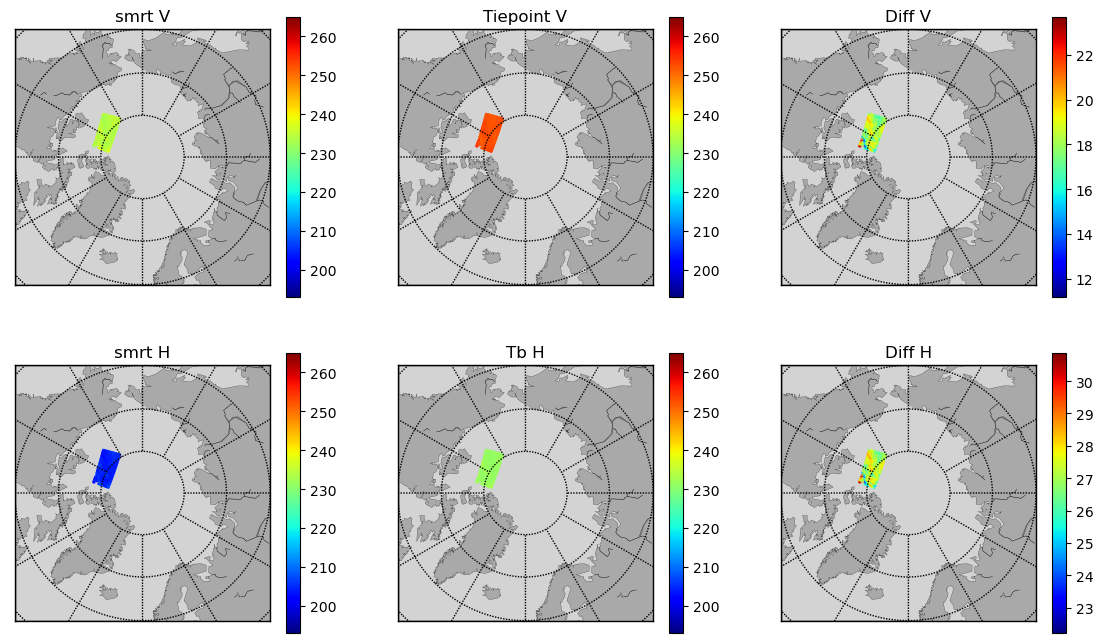

In [15]:
plt.figure(figsize=(14,8))

# Førsteårsis i baffin bay brug:
xR = [350,430]
yR = [320,350]

# Multiårs is nor for Grønland
xR = [450,500]
yR = [400,500]

# Is ved Round Robin
xR = [520,620]
yR = [330,380]

names = ['smrt V','Tiepoint V','Diff V','smrt H','Tb H','Diff H']
datas = [smrtV[0,0,xR[0]:xR[1],yR[0]:yR[1]],TbV[0,0,xR[0]:xR[1],yR[0]:yR[1]],TbV[0,0,xR[0]:xR[1],yR[0]:yR[1]]-smrtV[0,0,xR[0]:xR[1],yR[0]:yR[1]],
         smrtH[0,0,xR[0]:xR[1],yR[0]:yR[1]],TbH[0,0,xR[0]:xR[1],yR[0]:yR[1]],TbH[0,0,xR[0]:xR[1],yR[0]:yR[1]]-smrtH[0,0,xR[0]:xR[1],yR[0]:yR[1]]]

for i in range(len(names)):
    
    plt.subplot(231+i)

    
    if i % 3 == 2:
        ArcticPlot(lat[xR[0]:xR[1],yR[0]:yR[1]],lon[xR[0]:xR[1],yR[0]:yR[1]],datas[i])
    else:
        ArcticPlot(lat[xR[0]:xR[1],yR[0]:yR[1]],lon[xR[0]:xR[1],yR[0]:yR[1]],datas[i],193,265)

    plt.title(names[i])
    plt.colorbar()

plt.show()
    

# Define variable smrt profile parameters

Den her gang skal change være noget med at slå forskellige værdier op i et look-up table for at variere i profilet, med realistisk størrelser.

In [5]:
def smrt_profile(snowt,icet,Ts,icetype,change):
    #snowt: snow thickness [m]
    #icet: ice thickness [m]
    #Ts: thermometric temperature of the surface
    #icetype: first- or multiyear ice ['firstyear'/'multiyear']

    
    #compute num: layer number, top to bottom
    #total depth in cm
    hs=int(np.floor(snowt*100))
    hi=int(np.floor(icet*100))
    total_depth=int(hs+hi)
    num=np.array(range(total_depth))
    num=num+1
    
    #compute layer thickness
    di=0.1*np.ones(total_depth)
    
    #comute the thermometric temperature
    Ti=np.zeros(int(total_depth))
    snowtemp=np.zeros(int(hs))
    icetemp=np.zeros(int(hi))
    Tw=271.35 * change[1]
    ks=0.3 * change[2]
    ki=2.1 * change[3]
    #snedybden skal ikke være null her
    f=(ks*hi)/(ki*hs) 
    Tsi=(Tw+f*Ts)/(f+1)
    
    for i in range(hs):
        snowtemp[i]=Ts+i*(Tsi-Ts)/hs
    for j in range(hi):
        icetemp[j]=Tsi+j*(Tw-Tsi)/hi
        Ti[0:hs]=snowtemp[:]
        Ti[hs:hs+hi]=icetemp[:]
        
    #water content in the snow
    Wi=np.zeros(total_depth)
    
    #density profile : cox & weeks sammenhaeng mellem massefylde og saltindhold
    roi=np.zeros(total_depth)
    #snow density
    snow_density=np.ones(hs)
    w=int((np.floor(hs/4)))
    if hs < 4: snow_density[:]=330.0 * change[4]
    else:
        snow_density[0:w]=250.0 * change[5]
        snow_density[w:]=330.0 * change[4]
        snow_density=np.flipud(snow_density)
        
    ice_density=np.zeros(hi)
    #First-year ice density (icethickness)
    if icetype=='firstyear': 
        ice_density[:]=926.0 * change[6]
        
    #Multiyear ice density Hummock (icethickness)
    if icetype=='multiyear':
        humdens=np.zeros(20)
        tdens=750.0
        bdens=910.0
        for i in range(20):
            humdens[i]=tdens+i*(bdens-tdens)/20
        ice_density[0:20]=humdens[:]
        ice_density[20:hi]=bdens
        
    roi[0:hs]=snow_density[:]
    roi[hs:hs+hi]=ice_density[:]
    
    #the scattering correlation length
    snow_grain_size = 20 * change[7]
    pci=np.zeros(total_depth)
    snow_pcc=np.zeros(hs)
    ice_pcc=np.zeros(hi)
    for i in range(hs):
        snow_pcc[i] = 0.01*snow_grain_size*np.exp(-3.0*(i/hs))+0.07
    snow_pcc=np.flipud(snow_pcc)
    if icetype=='firstyear': ice_pcc[:]=0.1
    elif icetype=='multiyear': 
        ice_pcc[0:20]=0.8
        ice_pcc[20:hi]=0.2
    pci[0:hs]=snow_pcc[:]
    pci[hs:hi+hs]=ice_pcc[:]
    
    #the salinity
    snow_sal=np.zeros(hs)
    ice_sal=np.zeros(hi)
    simt=np.zeros(hi)
    sal=np.zeros(total_depth)
    CW2=(7.88* change[8])-(1.59* change[9])*(hi/100.0)
    
    #First-year ice snow and ice salinity
    if icetype=='firstyear':
        for i in range(hs):
            snow_sal[i] = 2*CW2*np.exp(-10.0*(i/hs))
        for j in range(hi):
            ice_sal[j]=(2*CW2*np.exp(-5*j/hi)+10.0*j/hi)*np.exp(-8.0*j/hi)+np.exp(2.5*j/hi)
    elif icetype=='multiyear':
        tsal=0.0
        bsal=5.0
        snow_sal[:]=0.0
        for j in range(hi):
            ice_sal[j]=tsal+j*(bsal-tsal)/hi
    sal[0:hs]=np.flipud(snow_sal[:])
    sal[hs:hi+hs]=ice_sal[:]
   
    typei=np.ones(total_depth)
    snow_type=np.ones(hs)
    idx=(snow_pcc > 0.2)
    snow_type[idx]=2.0
    ice_type=np.ones(hi)
    if icetype=='firstyear': ice_type[:]=3
    elif icetype=='multiyear': ice_type[:]=4
    
    typei[0:hs]=snow_type[:]
    typei[hs:hs+hi]=ice_type[:]
    
    si=np.zeros(total_depth)
    si[hs:hs+hi]=1.0
    
    return num, di, Ti, Wi, roi, pci, sal, typei, si

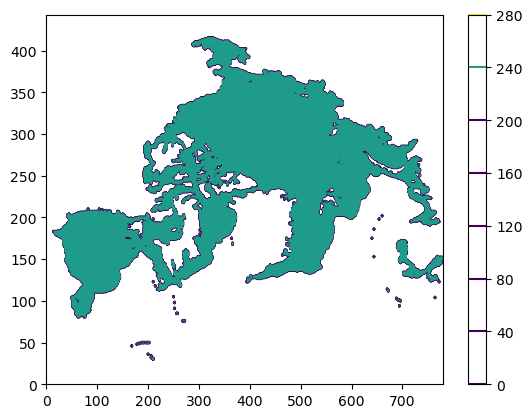

In [29]:
plt.contour(TbV[0,0,::2],vmin=200,vmax=273)
plt.colorbar()

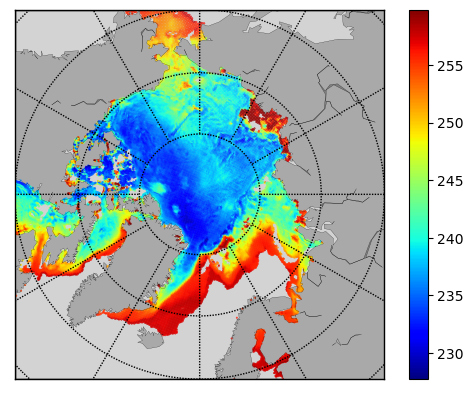

In [16]:
ArcticPlot(lat,lon,smrtV[0,0])
plt.colorbar()

In [ ]:
a